# Use the gym environment to experiment with different RL algorithms

In [1]:
from collections import Counter, defaultdict
import itertools

import numpy as np
import tensorflow as tf
import gym
from sklearn import preprocessing, pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

import matplotlib.pyplot as plt
%matplotlib inline

from utils import plotting

In [2]:
env = gym.make('MountainCar-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
env.action_space

Discrete(3)

In [4]:
env.observation_space.shape

(2,)

In [5]:
print(env.observation_space.high, env.observation_space.low)

[0.6  0.07] [-1.2  -0.07]


In [6]:
observation = env.reset()
print(observation)

[-0.55346402  0.        ]


In [7]:
print(env.step(env.action_space.sample()))

(array([-0.55424033, -0.00077631]), -1.0, False, {})


In [8]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = preprocessing.StandardScaler()
scaler.fit(observation_examples)
# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

# 1. TD(0) with function approximation

In [9]:
def epsilon_greedy_policy_function(s, epsilon, n_actions, estimator):
    '''
    Input state s, epsilon, and the number of possible actions
    return an array (A_probas) of probabilities corresponding to the actions.
    '''
    A_probas = (np.ones(n_actions) / n_actions) * epsilon # initialize uniformly scaled by epsilon 
    # get the Q values of all actions based on state for the function approximator
    q_values = estimator.predict(s)
    best_action = np.argmax(q_values)
    A_probas[best_action] += (1.0 - epsilon) 
    return A_probas

In [10]:
class Q_estimator(object):
    '''Q value function estimator.'''
    def __init__(self, n_state_features, n_actions, learning_rate=0.01):
        # a multi-task regression model that can be trained separately for each target
        self.n_actions = n_actions
        self.n_state_features = n_state_features
        self.state = tf.placeholder(tf.float32, 
                                    (None, n_state_features), 
                                    "state")
        self.q_values = tf.placeholder(tf.float32,
                                       (None, n_actions),
                                       "q_values"
                                      )
        self.is_training = tf.placeholder_with_default(True, (), 'is_training')

        self.q_values_pred = tf.contrib.layers.fully_connected(
            inputs=self.state,
            num_outputs=self.n_actions,
            activation_fn=None,
        )
        self.q_value_pred_list = [tf.expand_dims(self.q_values_pred[:, i], 1) \
                                  for i in range(self.n_actions)]

        self.losses = [tf.reduce_mean(tf.squared_difference(self.q_value_pred_list[i], 
                                                            tf.expand_dims(self.q_values[:, i], 1))) \
                       for i in range(self.n_actions)]

        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.train_ops = [self.optimizer.minimize(loss) for loss in self.losses]
        sess = tf.get_default_session()
        sess.run(tf.global_variables_initializer())

    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]

    def predict(self, state, sess=None):
        '''Make predictions given a state.
        return A_probas = Q(s) for a in all actions
        '''
        state = self.featurize_state(state)
        sess = sess or tf.get_default_session()
        return sess.run(self.q_values_pred, 
                        {self.state: state.reshape(1,-1), self.is_training: False
                        })

    def partial_fit(self, state, action, y, sess=None):
        '''Update the Q-value function estimator given 
        one (state, action, target(y)) tuple.
        '''
        sess = sess or tf.get_default_session()
        targets = np.zeros(self.n_actions)
        targets[action] = y
        state = self.featurize_state(state)
        sess.run([self.train_ops[action]], {self.state: state.reshape(1, -1), 
                                            self.q_values: targets.reshape(1, -1),
                                            self.is_training: True,
                                           })

In [11]:
# Init tf session
if tf.get_default_session() is None:
    sess = tf.InteractiveSession()

In [12]:
n_features = 400
estimator = Q_estimator(n_features, env.action_space.n, 
                        learning_rate=0.01)

In [13]:
n_episodes = 100
epsilon = 0.1
gamma = 1
actions = range(env.action_space.n)

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(n_episodes),
    episode_rewards=np.zeros(n_episodes))

for i in range(n_episodes):
    state = env.reset()
    done = False
    t = 0
    G = 0 # total return from this episode

    while not done:
        A_probas = epsilon_greedy_policy_function(state, epsilon, env.action_space.n, estimator)
        action = np.random.choice(actions, p=A_probas)
        
        next_state, reward, done, info = env.step(action)

        # Choose next action based on current policy 
        A_probas_next = epsilon_greedy_policy_function(next_state, epsilon, env.action_space.n, estimator)
        next_action = np.random.choice(actions, p=A_probas_next)
        # TD Target based on next action
        q_values_next = estimator.predict(next_state)
        td_target = reward + gamma * q_values_next[0, next_action]
        
        G += reward
        t += 1
        # Update Q-value estimator
        estimator.partial_fit(state, action, td_target)
        state = next_state
        
    stats.episode_rewards[i] = G
    stats.episode_lengths[i] = t
    
    if i % 20 == 0:
        print(i, G)

0 -200.0
20 -117.0
40 -146.0
60 -157.0
80 -143.0


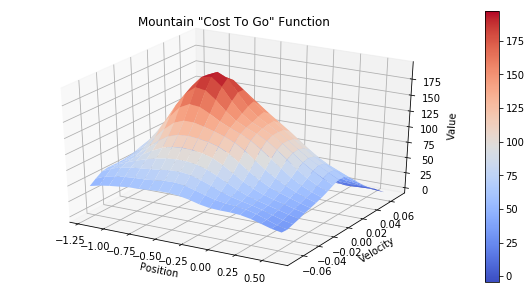

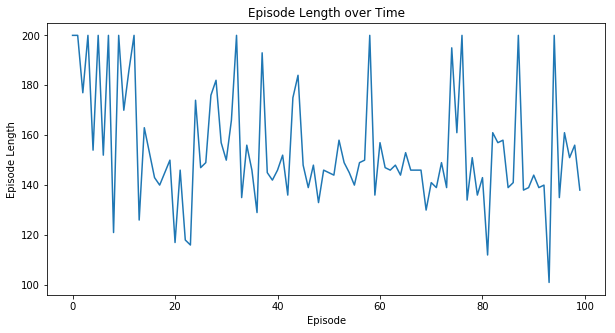

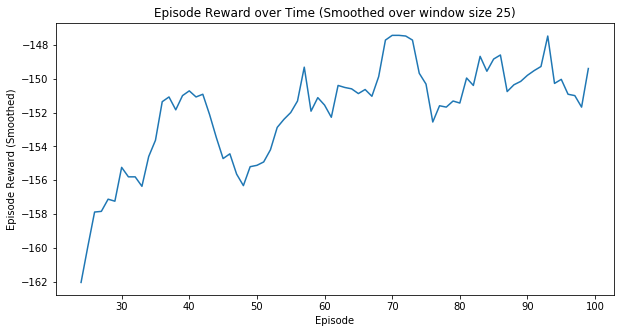

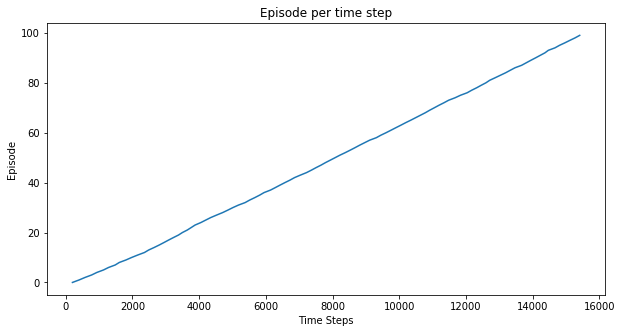

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [14]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

## 2. Q-learning off-policy control with function approximation

In [15]:
n_features = 400
estimator = Q_estimator(n_features, env.action_space.n, 
                        learning_rate=0.01)

In [16]:
n_episodes = 100
epsilon = 0.1
gamma = 1
actions = range(env.action_space.n)

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(n_episodes),
    episode_rewards=np.zeros(n_episodes))

for i in range(n_episodes):
    state = env.reset()
    done = False
    t = 0
    G = 0 # total return from this episode

    while not done:
        A_probas = epsilon_greedy_policy_function(state, epsilon, env.action_space.n, estimator)
        action = np.random.choice(actions, p=A_probas)
        
        next_state, reward, done, info = env.step(action)

        # TD Target for Q-learning is the max(Q) based on current Q estimator
        q_values_next = estimator.predict(next_state)
        td_target = reward + gamma * np.max(q_values_next[0])
        
        G += reward
        t += 1
        # Update Q-value estimator
        estimator.partial_fit(state, action, td_target)
        state = next_state
        
    stats.episode_rewards[i] = G
    stats.episode_lengths[i] = t
    
    if i % 20 == 0:
        print(i, G)

0 -200.0
20 -150.0
40 -158.0
60 -147.0
80 -148.0


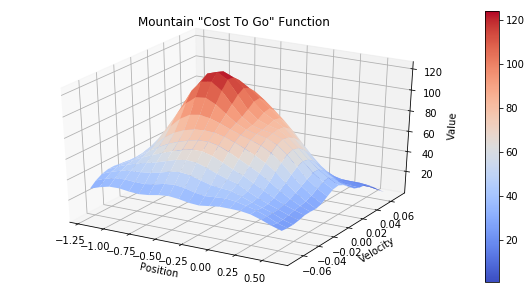

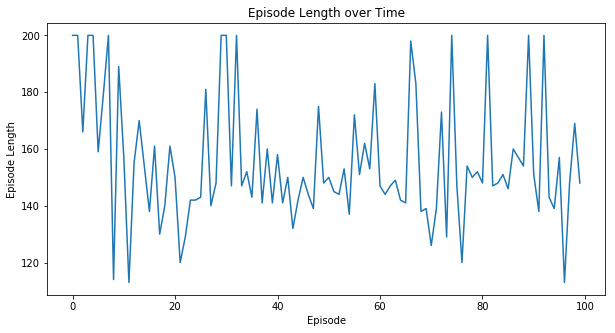

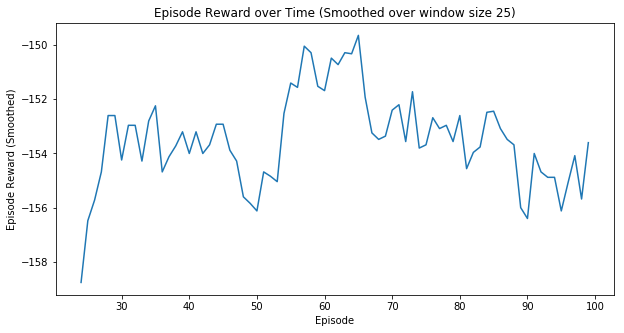

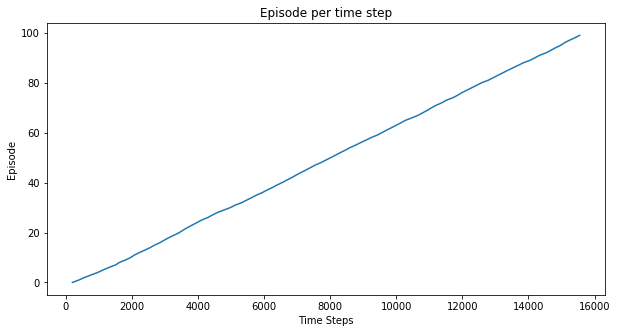

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [17]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)